In [16]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import copy
import io
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D


import torch
import torchvision
import torch
import torch.nn as nn
from torch import cuda
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.mps as mps



if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Using device: {device}")

import sys
sys.path.append('models_scratch/')
sys.path.append('data/')
from models_scratch import *
from data_utils import *

%matplotlib inline
sns.set(style="whitegrid")

Using device: cuda


In [2]:
def get_cifar10_train_loader(batch_size=256, size=32):
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root='data/', train=True, download=False, transform=transform)
    return trainset
def get_cifar10_test_loader(size=32):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    testset = torchvision.datasets.CIFAR10(root='data/', train=False, download=False, transform=transform)
    return testset 

trainset, testset = get_cifar10_train_loader(), get_cifar10_test_loader()

In [3]:
X_train = torch.stack([img for img, _ in trainset])
y_train = torch.tensor(trainset.targets)

X_test = torch.stack([img for img, _ in testset])
y_test = torch.tensor(testset.targets) 

def filter_cifar10(X, y, minority_class=1, minority_fraction=0.1):
 
    y = y.clone().detach()

    minority_indices = torch.where(y == minority_class)[0]
    majority_indices = torch.where(y != minority_class)[0]

    n1 = len(majority_indices)
    n0 = int(len(minority_indices) * minority_fraction)

    selected_minority_indices = minority_indices[torch.randperm(len(minority_indices))[:n0]]

    final_indices = torch.cat([selected_minority_indices, majority_indices])
    final_indices = final_indices[torch.randperm(len(final_indices))]

    S_filtered = torch.ones(len(y), dtype=torch.long)
    S_filtered[selected_minority_indices] = 0
    S_filtered = S_filtered[final_indices]

    return X[final_indices], y[final_indices], S_filtered

X_train, y_train, S_train = filter_cifar10(X_train, y_train, minority_fraction=0.1)
X_test, y_test, S_test = filter_cifar10(X_test, y_test, minority_fraction=0.1)

# Vérification des distributions des classes
print(f"Nombre d'éléments dans S_train=0: {(S_train == 0).sum().item()}")
print(f"Nombre d'éléments dans S_train=1: {(S_train == 1).sum().item()}")
print(f"Nombre d'éléments dans S_test=0: {(S_test == 0).sum().item()}")
print(f"Nombre d'éléments dans S_test=1: {(S_test == 1).sum().item()}")
print(f"Nombre d'éléments dans X_train=0: {len(X_train)}")

Nombre d'éléments dans S_train=0: 500
Nombre d'éléments dans S_train=1: 45000
Nombre d'éléments dans S_test=0: 100
Nombre d'éléments dans S_test=1: 9000
Nombre d'éléments dans X_train=0: 45500


In [4]:
def build_model(network, num_classes, input_channels, input_height, input_width, batch_norm = True, device='cuda'):
    
    if batch_norm:
        norm_layer = nn.BatchNorm2d
    else:
        norm_layer = None

    if network == "vgg11":
        net = VGG("VGG11", num_classes=num_classes, batch_norm=batch_norm)
    elif network == "vgg19":
        net = VGG("VGG19", num_classes=num_classes, batch_norm=batch_norm)
    elif network == "resnet18":
        net = resnet18(norm_layer=norm_layer, num_classes=num_classes)
    elif network == "resnet34":
        net = resnet34(norm_layer=norm_layer, num_classes=num_classes)
    elif network == "resnet50":
        net = resnet50(norm_layer=norm_layer, num_classes=num_classes)
    elif network == "densenet121":
        net = densenet121(norm_layer=norm_layer, num_classes=num_classes,
                          input_channels=input_channels, input_height=input_height, input_width=input_width)
    elif network == "mobilenet":
        net = MobileNet(num_classes=num_classes,
                          input_channels=input_channels, input_height=input_height, input_width=input_width)
    elif network == "squeezenet":
        net = SqueezeNet(num_classes=num_classes,
                          input_channels=input_channels, input_height=input_height, input_width=input_width)
    elif network == "lenet":
        net = LeNet5(num_classes=num_classes, input_channels=input_channels,
                     input_height=input_height, input_width=input_width)
    else:
        raise ValueError("Invalid network name.")

    net = net.to(device)
    
    num_params = sum(p.numel() for p in net.parameters())
    print(f"Total number of parameters in {network}: {num_params:,}")
    
    return net

net = build_model("vgg11", 10, 3, 32, 32, device)

Total number of parameters in vgg11: 9,231,114


In [5]:
def train_model(network, X_train, S_train, y_train, X_test, S_test, y_test, 
                epochs=10, batch_size=64, learning_rate=0.05, device='cpu', batch_norm=False, kappa=90, tau=90):
    
    trainset = TensorDataset(X_train, S_train, y_train)
    testset  = TensorDataset(X_test, S_test, y_test)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader  = DataLoader(testset, batch_size=100, shuffle=False)
    
    input_channels, input_height, input_width = X_train.shape[1], X_train.shape[2], X_train.shape[3]
    model = build_model(network, num_classes=10, input_channels=input_channels, 
                        input_height=input_height, input_width=input_width, device=device, batch_norm=batch_norm)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Initialisation des listes pour stocker les métriques par époque
    train_loss_s0, train_loss_s1, train_loss_all = [], [], []
    test_loss_s0, test_loss_s1, test_loss_all = [], [], []
    train_acc_s0, train_acc_s1, train_acc_all = [], [], []
    test_acc_s0, test_acc_s1, test_acc_all = [], [], []
    times, cumulative_time = [], 0
    
    early_stopping_epoch = None
    final_epoch = None

    # Initialisation des "meilleurs" scores (pour suivre l'évolution)
    best_train_loss_s0 = float('inf')
    best_train_loss_s1 = float('inf')
    best_train_loss    = float('inf')
    best_test_loss_s0  = float('inf')
    best_test_loss_s1  = float('inf')
    best_test_loss     = float('inf')
    best_train_acc_s0  = 0
    best_train_acc_s1  = 0
    best_train_acc     = 0
    best_test_acc_s0   = 0
    best_test_acc_s1   = 0
    best_test_acc      = 0
    
    nb_epochs = 0

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        
        total_loss, total_samples = 0.0, 0
        loss_s0_sum, count_s0 = 0.0, 0
        loss_s1_sum, count_s1 = 0.0, 0
        correct_total, correct_s0, correct_s1 = 0, 0, 0
        
        for X_batch, S_batch, y_batch in trainloader:
            X_batch, S_batch, y_batch = X_batch.to(device), S_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            bsize = y_batch.size(0)
            total_loss += loss.item() * bsize
            total_samples += bsize
            
            _, preds = outputs.max(1)
            correct_total += preds.eq(y_batch).sum().item()
            
            mask_s0 = (S_batch == 0)
            if mask_s0.any():
                n_s0 = mask_s0.sum().item()
                loss_s0 = criterion(outputs[mask_s0], y_batch[mask_s0]).item()
                loss_s0_sum += loss_s0 * n_s0
                count_s0 += n_s0
                correct_s0 += preds[mask_s0].eq(y_batch[mask_s0]).sum().item()
                
            mask_s1 = (S_batch == 1)
            if mask_s1.any():
                n_s1 = mask_s1.sum().item()
                loss_s1 = criterion(outputs[mask_s1], y_batch[mask_s1]).item()
                loss_s1_sum += loss_s1 * n_s1
                count_s1 += n_s1
                correct_s1 += preds[mask_s1].eq(y_batch[mask_s1]).sum().item()
        
        avg_loss    = total_loss / total_samples
        avg_loss_s0 = loss_s0_sum / count_s0 #total_samples 
        avg_loss_s1 = loss_s1_sum / count_s1 #total_samples
        
        acc_total = (correct_total / total_samples) * 100
        acc_s0    = (correct_s0 / count_s0) * 100
        acc_s1    = (correct_s1 / count_s1) * 100 
        
        best_train_loss_s0 = min(best_train_loss_s0, avg_loss_s0) #avg_loss_s0
        best_train_loss_s1 = min(best_train_loss_s1, avg_loss_s1) #avg_loss_s1
        best_train_loss    = min(best_train_loss, avg_loss) #avg_loss
        best_train_acc_s0  = max(best_train_acc_s0, acc_s0) #acc_s0
        best_train_acc_s1  = max(best_train_acc_s1, acc_s1) #acc_s1
        best_train_acc     = max(best_train_acc, acc_total) #acc_total
        
        train_loss_s0.append(best_train_loss_s0)
        train_loss_s1.append(best_train_loss_s1)
        train_loss_all.append(best_train_loss)
        train_acc_s0.append(best_train_acc_s0)
        train_acc_s1.append(best_train_acc_s1)
        train_acc_all.append(best_train_acc)
        
        if early_stopping_epoch is None and best_train_acc > tau:
            early_stopping_epoch = epoch + 1
        
        model.eval()
        test_loss_sum, total_test = 0.0, 0
        loss_s0_test_sum, count_s0_test = 0.0, 0
        loss_s1_test_sum, count_s1_test = 0.0, 0
        correct_test_total, correct_s0_test, correct_s1_test = 0, 0, 0
        
        with torch.no_grad():
            for X_batch, S_batch, y_batch in testloader:
                X_batch, S_batch, y_batch = X_batch.to(device), S_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                bsize = y_batch.size(0)
                test_loss_sum += loss.item() * bsize
                total_test += bsize
                
                _, preds = outputs.max(1)
                correct_test_total += preds.eq(y_batch).sum().item()
                
                mask_s0 = (S_batch == 0)
                if mask_s0.any():
                    n_s0 = mask_s0.sum().item()
                    loss_s0 = criterion(outputs[mask_s0], y_batch[mask_s0]).item()
                    loss_s0_test_sum += loss_s0 * n_s0
                    count_s0_test += n_s0
                    correct_s0_test += preds[mask_s0].eq(y_batch[mask_s0]).sum().item()
                
                mask_s1 = (S_batch == 1)
                if mask_s1.any():
                    n_s1 = mask_s1.sum().item()
                    loss_s1 = criterion(outputs[mask_s1], y_batch[mask_s1]).item()
                    loss_s1_test_sum += loss_s1 * n_s1
                    count_s1_test += n_s1
                    correct_s1_test += preds[mask_s1].eq(y_batch[mask_s1]).sum().item()
        
        avg_loss_test    = test_loss_sum / total_test
        avg_loss_s0_test = loss_s0_test_sum / count_s0_test #total_test
        avg_loss_s1_test = loss_s1_test_sum / count_s1_test #total_test
        
        acc_test         = (correct_test_total / total_test) * 100
        acc_s0_test      = (correct_s0_test / count_s0_test) * 100 if count_s0_test > 0 else 0
        acc_s1_test      = (correct_s1_test / count_s1_test) * 100 if count_s1_test > 0 else 0
        
        best_test_loss_s0 = min(best_test_loss_s0, avg_loss_s0_test) #avg_loss_s0_test 
        best_test_loss_s1 = min(best_test_loss_s1, avg_loss_s1_test) #avg_loss_s1_test
        best_test_loss    = min(best_test_loss, avg_loss_test) #avg_loss_test
        best_test_acc_s0  = max(best_test_acc_s0, acc_s0_test) #acc_s0_test
        best_test_acc_s1  = max(best_test_acc_s1, acc_s1_test) #acc_s1_test
        best_test_acc     = max(best_test_acc, acc_test) #acc_test
        
        test_loss_s0.append(best_test_loss_s0)
        test_loss_s1.append(best_test_loss_s1)
        test_loss_all.append(best_test_loss)
        test_acc_s0.append(best_test_acc_s0)
        test_acc_s1.append(best_test_acc_s1)
        test_acc_all.append(best_test_acc)
        
        cumulative_time += time.time() - start_time
        times.append(cumulative_time)
        
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Time: {cumulative_time:.2f}s")
            print(f"  Train -> Loss: S0={avg_loss_s0:.4f}, S1={avg_loss_s1:.4f}, Global={avg_loss:.4f} | "
                  f"Acc: S0={acc_s0:.2f}%, S1={acc_s1:.2f}%, Global={acc_total:.2f}%")
            print(f"  Test  -> Loss: S0={avg_loss_s0_test:.4f}, S1={avg_loss_s1_test:.4f}, Global={avg_loss_test:.4f} | "
                  f"Acc: S0={acc_s0_test:.2f}%, S1={acc_s1_test:.2f}%, Global={acc_test:.2f}%")
        #scheduler.step()
        nb_epochs += 1
        
        if best_train_acc_s0 > kappa:
            final_epoch = epoch + 1
            break
            
    if final_epoch is None:
        final_epoch = epochs

    debiasing_duration = (final_epoch - early_stopping_epoch) if early_stopping_epoch is not None else None

    print(f"\nTraining finished in {final_epoch} epochs.")
    if early_stopping_epoch:
        print(f"→ Early stopping threshold (Acc > τ={tau}%) reached at epoch {early_stopping_epoch}.")
    print(f"→ Fairness threshold (Acc_S=0 > κ={kappa}%) reached at epoch {final_epoch}.")
    if early_stopping_epoch:
        print(f"→ Debiasing duration: {debiasing_duration} epochs.")

    return {
         "times": np.array(times),
         "epoch": np.arange(1, nb_epochs + 1),
         "train_loss_s0": np.array(train_loss_s0),
         "train_loss_s1": np.array(train_loss_s1),
         "train_loss_all": np.array(train_loss_all),
         "test_loss_s0": np.array(test_loss_s0),
         "test_loss_s1": np.array(test_loss_s1),
         "test_loss_all": np.array(test_loss_all),
         "train_acc_s0": np.array(train_acc_s0),
         "train_acc_s1": np.array(train_acc_s1),
         "train_acc_all": np.array(train_acc_all),
         "test_acc_s0": np.array(test_acc_s0),
         "test_acc_s1": np.array(test_acc_s1),
         "test_acc_all": np.array(test_acc_all)
    }

In [6]:
def run_multiple_experiments(network, X_train, S_train, y_train, X_test, S_test, y_test,
                             epochs=10, batch_size=64, learning_rate=0.05, device='cpu', num_runs=5, batch_norm=False):
    records = []
    
    for run in range(num_runs):
        print(f"\n--- Run {run+1}/{num_runs} ---")
        result = train_model(network, X_train, S_train, y_train, X_test, S_test, y_test,
                             epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, device=device, batch_norm=batch_norm)
        for i, epoch in enumerate(result["epoch"]):
            record = {
                "num_run": run+1,
                "epoch": result["epoch"][i],
                "time": result["times"][i],
                "train_loss_all": result["train_loss_all"][i],
                "train_loss_s0": result["train_loss_s0"][i],
                "train_loss_s1": result["train_loss_s1"][i],
                "test_loss_all": result["test_loss_all"][i],
                "test_loss_s0": result["test_loss_s0"][i],
                "test_loss_s1": result["test_loss_s1"][i],
                "train_acc_all": result["train_acc_all"][i],
                "train_acc_s0": result["train_acc_s0"][i],
                "train_acc_s1": result["train_acc_s1"][i],
                "test_acc_all": result["test_acc_all"][i],
                "test_acc_s0": result["test_acc_s0"][i],
                "test_acc_s1": result["test_acc_s1"][i],
            }
            records.append(record)
    
    df = pd.DataFrame(records)
    df["epoch"] = df["epoch"].astype(int)  # s'assurer que les epochs sont en entier
    
    return df

def run_experiments_for_imbalances(network, X_train, y_train, X_test, y_test,
                                   imbalance_values=[0.01, 0.2, 0.8],
                                   epochs_list=[1000, 200, 300],
                                   num_runs=3, batch_size=128,
                                   learning_rate=1e-4, device='cuda', batch_norm=False):
    df_list = []

    for frac, epochs in zip(imbalance_values, epochs_list):
        print(f"\n=== Imbalance: {int(frac*100)}%, {epochs} epochs ===")

        # Filtrage des données
        X_train_f, y_train_f, S_train_f = filter_cifar10(X_train, y_train, minority_fraction=frac)
        X_test_f, y_test_f, S_test_f = filter_cifar10(X_test, y_test, minority_fraction=frac)

        # Lancement des expériences
        df_frac = run_multiple_experiments(network, X_train_f, S_train_f, y_train_f,
                                           X_test_f, S_test_f, y_test_f,
                                           epochs=epochs, batch_size=batch_size,
                                           learning_rate=learning_rate, device=device, num_runs=num_runs, batch_norm=batch_norm)

        # Ajout des infos de contexte
        df_frac["imbalance"] = int(frac * 100)
        #df_frac["epoch"] = list(range(epoch_count)) * num_runs
        df_list.append(df_frac)

    df_all = pd.concat(df_list, ignore_index=True)
    return df_all


In [7]:
def plot_xp(df,network):
    # Transformation en format long pour tracer avec seaborn
    df_loss_train = df.melt(id_vars=["num_run", "epoch", "time"], 
                            value_vars=["train_loss_all", "train_loss_s0", "train_loss_s1"],
                            var_name="group", value_name="train_loss")
    df_loss_test = df.melt(id_vars=["num_run", "epoch", "time"], 
                           value_vars=["test_loss_all", "test_loss_s0", "test_loss_s1"],
                           var_name="group", value_name="test_loss")
    df_acc_train = df.melt(id_vars=["num_run", "epoch", "time"], 
                           value_vars=["train_acc_all", "train_acc_s0", "train_acc_s1"],
                           var_name="group", value_name="train_acc")
    df_acc_test = df.melt(id_vars=["num_run", "epoch", "time"], 
                          value_vars=["test_acc_all", "test_acc_s0", "test_acc_s1"],
                          var_name="group", value_name="test_acc")
    
    # Remplacement des noms pour la légende
    mapping_loss = {
        "train_loss_all": "Global",
        "train_loss_s0": "S=0",
        "train_loss_s1": "S=1",
        "test_loss_all": "Global",
        "test_loss_s0": "S=0",
        "test_loss_s1": "S=1"
    }
    mapping_acc = {
        "train_acc_all": "Global",
        "train_acc_s0": "S=0",
        "train_acc_s1": "S=1",
        "test_acc_all": "Global",
        "test_acc_s0": "S=0",
        "test_acc_s1": "S=1"
    }
    df_loss_train["group"] = df_loss_train["group"].map(mapping_loss)
    df_loss_test["group"] = df_loss_test["group"].map(mapping_loss)
    df_acc_train["group"] = df_acc_train["group"].map(mapping_acc)
    df_acc_test["group"] = df_acc_test["group"].map(mapping_acc)
    
    palette = {"S=0": "blue", "S=1": "orange", "Global": "green"}
    #palette = sns.color_palette("hls", 3)
    
    # Tracé des courbes avec sns.lineplot
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    
    ax0 = axs[0, 0]
    sns.lineplot(ax=ax0, data=df_loss_train, x="epoch", y="train_loss", hue="group", 
                 estimator='mean', errorbar='sd', palette=palette) #ci
    ax0.set_yscale("log")
    ax0.set_xlabel("Epoch")
    ax0.set_ylabel("Train loss")
    
    ax1 = axs[0, 1]
    sns.lineplot(ax=ax1, data=df_loss_test, x="epoch", y="test_loss", hue="group", 
                 estimator='mean', errorbar='sd', palette=palette)
    ax1.set_yscale("log")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Test loss")
    
    ax2 = axs[1, 0]
    sns.lineplot(ax=ax2, data=df_acc_train, x="epoch", y="train_acc", hue="group", 
                 estimator='mean', errorbar='sd', palette=palette)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Train accuracy")
    
    ax3 = axs[1, 1]
    sns.lineplot(ax=ax3, data=df_acc_test, x="epoch", y="test_acc", hue="group", 
                 estimator='mean', errorbar='sd', palette=palette)
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Test accuracy")
    
    # Supprimer les légendes individuelles de chaque sous-graphe
    for ax in axs.flat:
        ax.get_legend().remove()
    
    # Récupérer handles et labels à partir d'un des axes (ils sont identiques pour tous)
    handles, labels = ax0.get_legend_handles_labels()
    # Ajouter une légende globale à la figure
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))
    
    # S'assurer que l'axe x affiche des entiers
    for ax in axs.flat:
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.tight_layout()
    #plt.subplots_adjust(bottom=0.2) 
    plt.savefig(f"results/CIFAR-2/{network}_multi_run_metrics.pdf", bbox_inches="tight")
    plt.show()

In [9]:
df_results = run_experiments_for_imbalances("resnet18", X_train, y_train, X_test, y_test,
                                            imbalance_values=[0.5],
                                            num_runs=1, epochs_list=[10000, 100000], batch_size=128,
                                            learning_rate=1e-3, device='cuda', batch_norm=False)


=== Imbalance: 50%, 10000 epochs ===

--- Run 1/1 ---
Total number of parameters in resnet18: 11,164,362
Epoch [1/10000] | Time: 3.36s
  Train -> Loss: S0=5.1631, S1=2.1031, Global=2.1201 | Acc: S0=0.00%, S1=21.73%, Global=21.61%
  Test  -> Loss: S0=5.4858, S1=1.9734, Global=1.9929 | Acc: S0=0.00%, S1=26.91%, Global=26.76%
Epoch [50/10000] | Time: 166.27s
  Train -> Loss: S0=2.6839, S1=0.8400, Global=0.8502 | Acc: S0=13.60%, S1=70.58%, Global=70.27%
  Test  -> Loss: S0=2.9538, S1=1.0602, Global=1.0707 | Acc: S0=6.00%, S1=63.00%, Global=62.69%
Epoch [100/10000] | Time: 330.80s
  Train -> Loss: S0=0.4547, S1=0.1914, Global=0.1929 | Acc: S0=88.00%, S1=95.63%, Global=95.59%
  Test  -> Loss: S0=2.8624, S1=1.5462, Global=1.5535 | Acc: S0=18.00%, S1=62.64%, Global=62.40%

Training finished in 102 epochs.
→ Early stopping threshold (Acc > τ=90%) reached at epoch 89.
→ Fairness threshold (Acc_S=0 > κ=90%) reached at epoch 102.
→ Debiasing duration: 13 epochs.


In [29]:
def plot_metrics_by_imbalance(df, network, kappa):

    os.makedirs("results/CIFAR-10", exist_ok=True)
    n_epochs = int(df["epoch"].max())
    pdf_path = f"results/CIFAR-10/{network}_metrics_by_imbalance_{n_epochs}epochs.pdf"
    
    df_loss_train = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                            value_vars=["train_loss_all", "train_loss_s0", "train_loss_s1"],
                            var_name="group", value_name="train_loss")
    df_loss_test = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                           value_vars=["test_loss_all", "test_loss_s0", "test_loss_s1"],
                           var_name="group", value_name="test_loss")
    df_acc_train = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                           value_vars=["train_acc_all", "train_acc_s0", "train_acc_s1"],
                           var_name="group", value_name="train_acc")
    df_acc_test = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                          value_vars=["test_acc_all", "test_acc_s0", "test_acc_s1"],
                          var_name="group", value_name="test_acc")

    mapping_loss = {
        "train_loss_all": "Global", "train_loss_s0": "S=0", "train_loss_s1": "S=1",
        "test_loss_all": "Global", "test_loss_s0": "S=0", "test_loss_s1": "S=1"
    }
    mapping_acc = {
        "train_acc_all": "Global", "train_acc_s0": "S=0", "train_acc_s1": "S=1",
        "test_acc_all": "Global", "test_acc_s0": "S=0", "test_acc_s1": "S=1"
    }

    df_loss_train["group"] = df_loss_train["group"].map(mapping_loss)
    df_loss_test["group"] = df_loss_test["group"].map(mapping_loss)
    df_acc_train["group"] = df_acc_train["group"].map(mapping_acc)
    df_acc_test["group"] = df_acc_test["group"].map(mapping_acc)

    palette = {"S=0": "blue", "S=1": "orange", "Global": "green"}
    imbalance_levels = sorted(df["imbalance"].unique())
    n_cols = len(imbalance_levels)

    fig, axes = plt.subplots(4, n_cols, figsize=(5 * n_cols, 12))
    if n_cols == 1:
        axes = axes.reshape(4, 1)

    def plot_metric(ax, data, y_value, log_scale=False):
        sns.lineplot(data=data, x="epoch", y=y_value, hue="group",
                     estimator="mean", errorbar="sd", palette=palette, ax=ax, legend=False)
        if log_scale:
            ax.set_yscale("log")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for col_idx, imbalance in enumerate(imbalance_levels):
        subset_train_loss = df_loss_train[df_loss_train["imbalance"] == imbalance]
        subset_test_loss = df_loss_test[df_loss_test["imbalance"] == imbalance]
        subset_train_acc = df_acc_train[df_acc_train["imbalance"] == imbalance]
        subset_test_acc = df_acc_test[df_acc_test["imbalance"] == imbalance]

        plot_metric(axes[0, col_idx], subset_train_loss, "train_loss", log_scale=True)
        axes[0, col_idx].set_title(rf"$\rho$ = {imbalance}%")

        plot_metric(axes[1, col_idx], subset_test_loss, "test_loss", log_scale=True)
        plot_metric(axes[2, col_idx], subset_train_acc, "train_acc")
        plot_metric(axes[3, col_idx], subset_test_acc, "test_acc")
        
        axes[2, col_idx].axhline(kappa, color='red', linestyle='--', linewidth=1)
        label_text = r"$\kappa$"

        axes[2, col_idx].annotate(label_text,
                          xy=(-0.05, kappa),  # 1.01 = juste à droite
                          xycoords=('axes fraction', 'data'),
                          fontsize=10, color='red',
                          va='center', ha='right')

        axes[3, col_idx].set_xlabel("Epoch")

    axes[0, 0].set_ylabel("Train loss")
    axes[1, 0].set_ylabel("Test loss")
    axes[2, 0].set_ylabel("Train accuracy (%)")
    axes[3, 0].set_ylabel("Test accuracy (%)")


    for col in range(1, n_cols):
        axes[0, col].set_ylabel("")
        axes[1, col].set_ylabel("")
        axes[2, col].set_ylabel("")
        axes[3, col].set_ylabel("")
        
    for row in range(1, 4):
        for col in range(n_cols):
            axes[row, col].set_title("")

    # Supprimer l'étiquette "Epoch" sur toutes les lignes sauf la dernière
    for row in range(3):
        for col in range(n_cols):
            axes[row, col].set_xlabel("")

    # Global legend
    group_legend = [Line2D([0], [0], color=color, lw=2, label=label)
                    for label, color in palette.items()]
    red_line = Line2D([0], [0], color='red', lw=1, linestyle='--', label=r"$\kappa$ threshold")
    fig.legend(group_legend + [red_line], [*palette.keys(), r"$\kappa$ threshold"],
               loc="upper center", ncol=4, fontsize=10, bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(pdf_path, bbox_inches="tight")

In [30]:
def plot_metrics_by_imbalance(df, network, kappa, show_test=False):
    os.makedirs("results/CIFAR-10", exist_ok=True)
    n_epochs = int(df["epoch"].max())
    suffix = "_with_test" if show_test else "_train_only"
    pdf_path = f"results/CIFAR-10/{network}_metrics_by_imbalance_kappa_{kappa}{suffix}.pdf"
    
    df_loss_train = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                            value_vars=["train_loss_all", "train_loss_s0", "train_loss_s1"],
                            var_name="group", value_name="train_loss")
    df_acc_train = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                           value_vars=["train_acc_all", "train_acc_s0", "train_acc_s1"],
                           var_name="group", value_name="train_acc")

    if show_test:
        df_loss_test = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                               value_vars=["test_loss_all", "test_loss_s0", "test_loss_s1"],
                               var_name="group", value_name="test_loss")
        df_acc_test = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                              value_vars=["test_acc_all", "test_acc_s0", "test_acc_s1"],
                              var_name="group", value_name="test_acc")

    mapping = {
        "train_loss_all": "Global", "train_loss_s0": "S=0", "train_loss_s1": "S=1",
        "test_loss_all": "Global", "test_loss_s0": "S=0", "test_loss_s1": "S=1",
        "train_acc_all": "Global", "train_acc_s0": "S=0", "train_acc_s1": "S=1",
        "test_acc_all": "Global", "test_acc_s0": "S=0", "test_acc_s1": "S=1"
    }

    df_loss_train["group"] = df_loss_train["group"].map(mapping)
    df_acc_train["group"] = df_acc_train["group"].map(mapping)
    if show_test:
        df_loss_test["group"] = df_loss_test["group"].map(mapping)
        df_acc_test["group"] = df_acc_test["group"].map(mapping)

    palette = {"S=0": "blue", "S=1": "orange", "Global": "green"}
    imbalance_levels = sorted(df["imbalance"].unique())
    n_cols = len(imbalance_levels)
    n_rows = 4 if show_test else 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.2 * n_rows))
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    def plot_metric(ax, data, y_value, log_scale=False):
        sns.lineplot(data=data, x="epoch", y=y_value, hue="group",
                     estimator="mean", errorbar="sd", palette=palette, ax=ax, legend=False)
        if log_scale:
            ax.set_yscale("log")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for col_idx, imbalance in enumerate(imbalance_levels):
        subset_train_loss = df_loss_train[df_loss_train["imbalance"] == imbalance]
        subset_train_acc = df_acc_train[df_acc_train["imbalance"] == imbalance]
        plot_metric(axes[0, col_idx], subset_train_loss, "train_loss", log_scale=True)
        axes[0, col_idx].set_title(rf"$\rho$ = {imbalance}%")
        plot_metric(axes[1 if not show_test else 2, col_idx], subset_train_acc, "train_acc")
        axes[1 if not show_test else 2, col_idx].axhline(kappa, color='red', linestyle='--', linewidth=1)

        if show_test:
            subset_test_loss = df_loss_test[df_loss_test["imbalance"] == imbalance]
            subset_test_acc = df_acc_test[df_acc_test["imbalance"] == imbalance]
            plot_metric(axes[1, col_idx], subset_test_loss, "test_loss", log_scale=True)
            plot_metric(axes[3, col_idx], subset_test_acc, "test_acc")
            axes[3, col_idx].set_xlabel("Epoch")

        if col_idx == 0:
            axes[1 if not show_test else 2, col_idx].annotate(
                rf"$\kappa$ = {int(kappa)}", xy=(-0.05, kappa), xycoords=('axes fraction', 'data'),
                fontsize=10, color='red', va='center', ha='right')

    axes[0, 0].set_ylabel("Train loss")
    axes[1 if not show_test else 2, 0].set_ylabel("Train accuracy (%)")
    if show_test:
        axes[1, 0].set_ylabel("Test loss")
        axes[3, 0].set_ylabel("Test accuracy (%)")

    for row in range(1, n_rows):
        for col in range(n_cols):
            if row != 1 or show_test:
                axes[row, col].set_ylabel("")
            axes[row, col].set_title("")
            if row < n_rows - 1:
                axes[row, col].set_xlabel("")

    legend_elements = [Line2D([0], [0], color=color, lw=2, label=label) for label, color in palette.items()]
    red_line = Line2D([0], [0], color='red', lw=1, linestyle='--', label=r"$\kappa$ threshold")
    fig.legend(legend_elements + [red_line], [*palette.keys(), r"$\kappa$ threshold"],
               loc="upper center", ncol=4, fontsize=10, bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

def plot_metrics_by_imbalance(df, network, kappa, show_test=True):
    import os
    os.makedirs("results/CIFAR-10", exist_ok=True)
    n_epochs = int(df["epoch"].max())
    pdf_path = f"results/CIFAR-10/{network}_metrics_by_imbalance_kappa_{kappa}_{'with_test' if show_test else 'train_only'}.pdf"
    
    df_loss_train = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                            value_vars=["train_loss_all", "train_loss_s0", "train_loss_s1"],
                            var_name="group", value_name="train_loss")
    df_acc_train = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                           value_vars=["train_acc_all", "train_acc_s0", "train_acc_s1"],
                           var_name="group", value_name="train_acc")

    df_loss_test, df_acc_test = None, None
    if show_test:
        df_loss_test = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                               value_vars=["test_loss_all", "test_loss_s0", "test_loss_s1"],
                               var_name="group", value_name="test_loss")
        df_acc_test = df.melt(id_vars=["num_run", "epoch", "time", "imbalance"],
                              value_vars=["test_acc_all", "test_acc_s0", "test_acc_s1"],
                              var_name="group", value_name="test_acc")

    mapping = {
        "train_loss_all": "Global", "train_loss_s0": "S=0", "train_loss_s1": "S=1",
        "test_loss_all": "Global", "test_loss_s0": "S=0", "test_loss_s1": "S=1",
        "train_acc_all": "Global", "train_acc_s0": "S=0", "train_acc_s1": "S=1",
        "test_acc_all": "Global", "test_acc_s0": "S=0", "test_acc_s1": "S=1"
    }

    df_loss_train["group"] = df_loss_train["group"].map(mapping)
    df_acc_train["group"] = df_acc_train["group"].map(mapping)
    if show_test:
        df_loss_test["group"] = df_loss_test["group"].map(mapping)
        df_acc_test["group"] = df_acc_test["group"].map(mapping)

    palette = {"S=0": "blue", "S=1": "orange", "Global": "green"}
    imbalance_levels = sorted(df["imbalance"].unique())
    n_cols = len(imbalance_levels)
    n_rows = 4 if show_test else 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    def plot_metric(ax, data, y_value, log_scale=False):
        sns.lineplot(data=data, x="epoch", y=y_value, hue="group",
                     estimator="mean", errorbar="sd", palette=palette, ax=ax, legend=False)
        if log_scale:
            ax.set_yscale("log")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for col_idx, imbalance in enumerate(imbalance_levels):
        plot_metric(axes[0, col_idx], df_loss_train[df_loss_train["imbalance"] == imbalance], "train_loss", log_scale=True)
        axes[0, col_idx].set_title(rf"$\rho$ = {imbalance}%")

        plot_metric(axes[1, col_idx], df_acc_train[df_acc_train["imbalance"] == imbalance], "train_acc")
        axes[1, col_idx].axhline(kappa, color='red', linestyle='--', linewidth=1)
        if col_idx == 0:
            axes[1, col_idx].annotate(rf"$\kappa$ = {int(kappa)}",
                                      xy=(-0.05, kappa),
                                      xycoords=('axes fraction', 'data'),
                                      fontsize=10, color='red',
                                      va='center', ha='right')

        if show_test:
            plot_metric(axes[2, col_idx], df_loss_test[df_loss_test["imbalance"] == imbalance], "test_loss", log_scale=True)
            plot_metric(axes[3, col_idx], df_acc_test[df_acc_test["imbalance"] == imbalance], "test_acc")
            axes[3, col_idx].set_xlabel("Epoch")

    axes[0, 0].set_ylabel("Train loss")
    axes[1, 0].set_ylabel("Train accuracy (%)")
    if show_test:
        axes[2, 0].set_ylabel("Test loss")
        axes[3, 0].set_ylabel("Test accuracy (%)")

    for row in range(n_rows):
        for col in range(1, n_cols):
            axes[row, col].set_ylabel("")
        for col in range(n_cols):
            if row < (n_rows - 1):
                axes[row, col].set_xlabel("")
            else:
                axes[row, col].set_xlabel("Epoch")

    group_legend = [Line2D([0], [0], color=color, lw=2, label=label)
                    for label, color in palette.items()]
    red_line = Line2D([0], [0], color='red', lw=1, linestyle='--', label=r"$\kappa$ threshold")
    fig.legend(group_legend + [red_line], [*palette.keys(), r"$\kappa$ threshold"],
               loc="upper center", ncol=4, fontsize=10, bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    return pdf_path

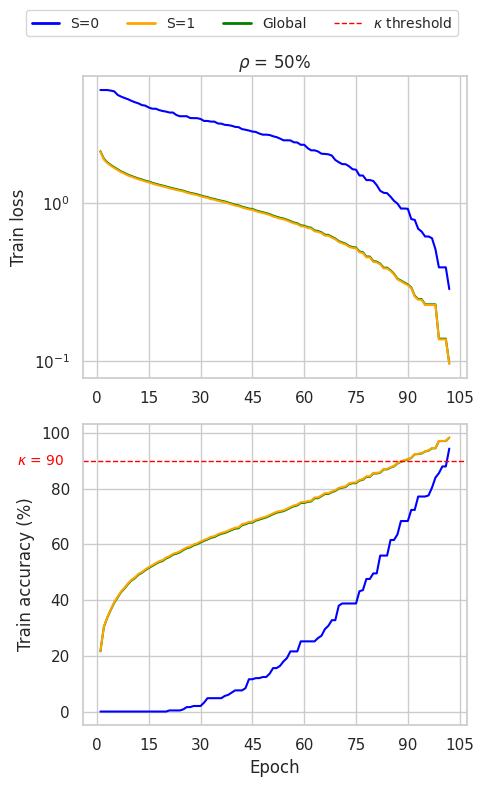

'results/CIFAR-10/resnet18_metrics_by_imbalance_kappa_90_train_only.pdf'

In [47]:
plot_metrics_by_imbalance(df_results, "resnet18", 90, show_test=False)